In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show(img, title="", cmap="gray", size=6):
    plt.figure(figsize=(size, size))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

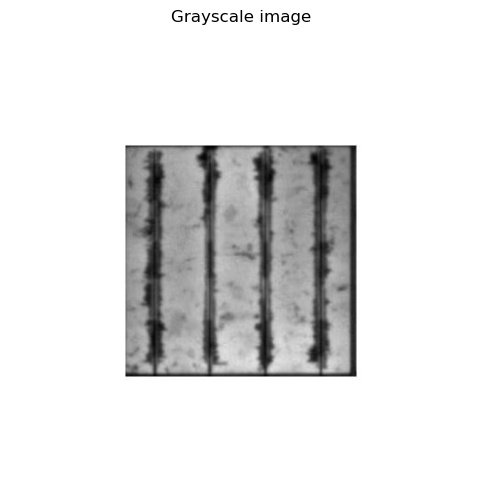

In [21]:
image = cv2.imread(r"D:\PROGRAMMING\Internships_assignments\ResearchInternIITMandi\dataset\dataset\flip_180_SDLE_00514_A10-DH3000-3000h-PT-cell46.png", cv2.IMREAD_GRAYSCALE)
show(image, "Grayscale image")

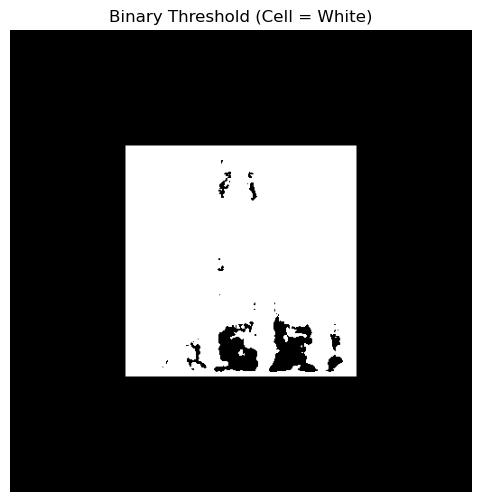

In [22]:
_, thresh = cv2.threshold(
    image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

show(thresh, "Binary Threshold (Cell = White)")

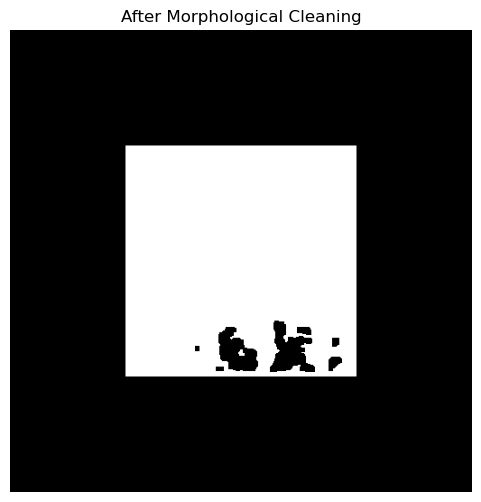

In [23]:
kernel = np.ones((5, 5), np.uint8)
clean = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

show(clean, "After Morphological Cleaning")


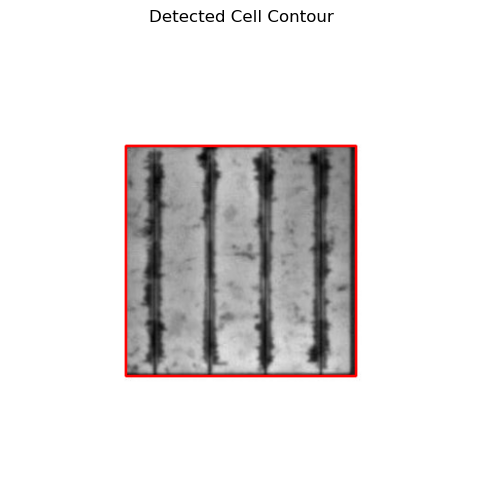

In [24]:
contours, _ = cv2.findContours(
    clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Pick the largest contour
cell_contour = max(contours, key=cv2.contourArea)

# Visualize contour
contour_vis = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
cv2.drawContours(contour_vis, [cell_contour], -1, (255, 0, 0), 2)

show(contour_vis, "Detected Cell Contour")


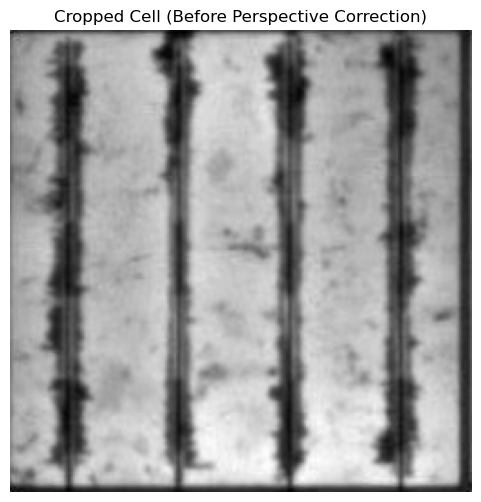

In [25]:
x, y, w, h = cv2.boundingRect(cell_contour)
cell_crop = image[y:y+h, x:x+w]

show(cell_crop, "Cropped Cell (Before Perspective Correction)")


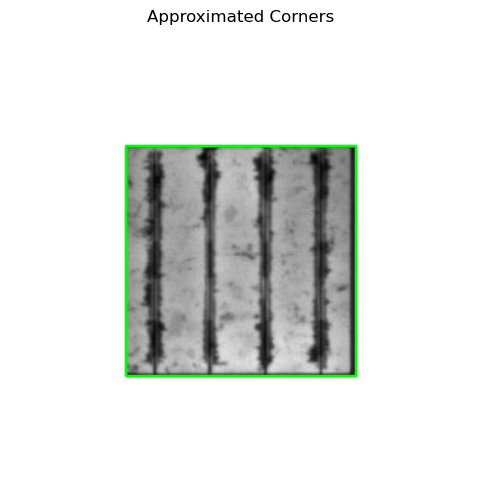

In [26]:
# Approximate contour to polygon
epsilon = 0.02 * cv2.arcLength(cell_contour, True)
approx = cv2.approxPolyDP(cell_contour, epsilon, True)

approx_vis = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
cv2.drawContours(approx_vis, [approx], -1, (0, 255, 0), 2)

show(approx_vis, "Approximated Corners")


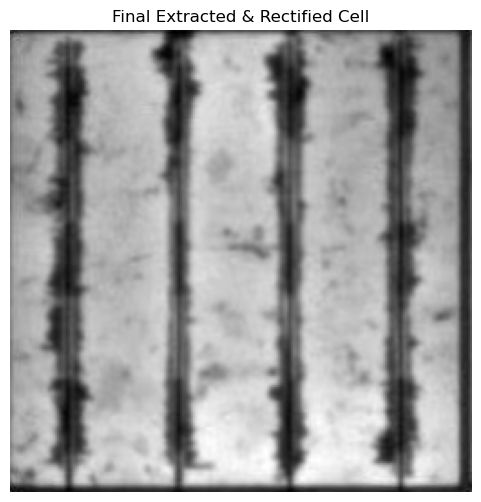

In [27]:
if len(approx) == 4:
    pts = approx.reshape(4, 2)

    # Order points: top-left, top-right, bottom-right, bottom-left
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)

        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    rect = order_points(pts)

    (tl, tr, br, bl) = rect
    width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
    height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))

    dst = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (width, height))

    show(warped, "Final Extracted & Rectified Cell")
else:
    print("Perspective correction skipped: 4 corners not found")
